# DAT200 CA5 2022

Kaggle username: karinmollatt

---

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector

# remove weak warnings
import warnings
warnings.filterwarnings('ignore')

### Reading data

In [2]:
# loading data
train_df =  pd.read_csv('data/train.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

### Data exploration and visualisation
I visualize the raw data with violin- and boxplots to inspect for possible outliers or inconsistencies, and to observe if this can have an impact on the model afterwards.

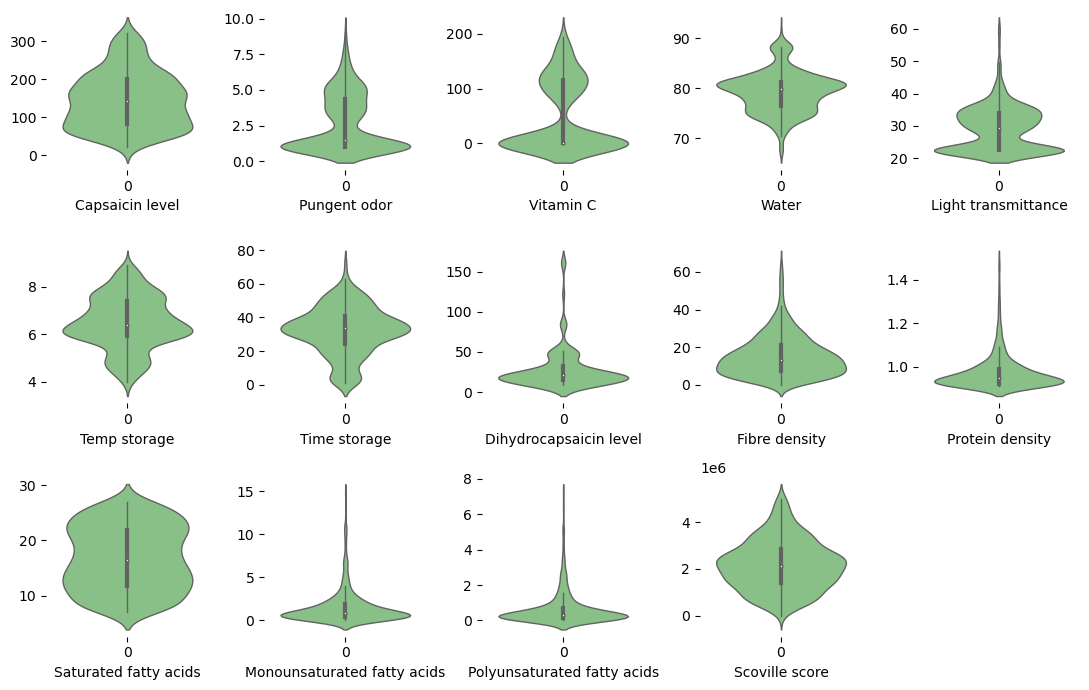

In [3]:
# violinplot of each feature
row_no = 3
col_no = 5
subplot_no = 1

plt.figure(figsize=(11,7))

for col in train_df.columns:
    plt.subplot(row_no, col_no, subplot_no)
    plt.xlabel(col)
    sns.violinplot(data=train_df[col], linewidth=1, palette='Accent')
    subplot_no = subplot_no + 1

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

From the violinplots one can observe that only a few of the features are normally distributed. This accounts `Time storage`, `Temp storage` (if one is a bit inclusive) and the target values in `Scoville score`. For the rest of the features, some have bi- or multimodal distributions, meaning they have two or more peaks.

<Figure size 640x480 with 0 Axes>

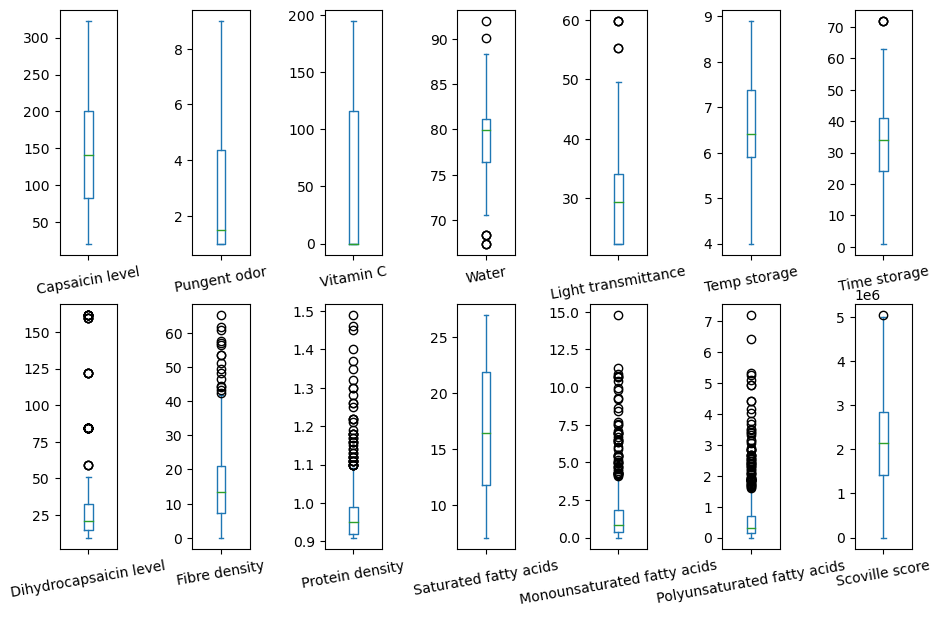

In [4]:
# box plot
plt.figure()
train_df.plot(kind='box', 
              subplots=True, 
              layout=(2, 7),
              figsize=(11,7),
              sharex=False, 
              sharey=False,
              rot=10)
plt.subplots_adjust(wspace=1.3) 
plt.show()

From the three visualizations of the raw data, one can observe that some of the continous features have skewed distributions, which is a sign of the data containing outliers. This applies to `Dihydrocapsaicin level`, `Fibre density`, `Protein density`, `Monounsaturated fatty acids` and `Polyunsaturared fatty acids`.

### Data cleaning

Firstly, one wants to detect null values, to either remove them or replace them with the mean imputation.

In [5]:
no_null_train = train_df.isnull().sum()
no_null_test = test_df.isnull().sum()

print(f'Number of missing values in training dataset:\n{no_null_train}')
print(f'\nIn total {no_null_train.sum()} missing values, which applies to {no_null_train.sum()/len(train_df)*100:.2f}% of the data.')

print(f'\nNumber of missing values in test dataset:\n{no_null_test}')
print(f'\nIn total {no_null_test.sum()} missing values, which applies to {no_null_test.sum()/len(test_df)*100:.2f}% of the data.')

Number of missing values in training dataset:
Capsaicin level                0
Pungent odor                   0
Vitamin C                      0
Water                          0
Light transmittance            0
Temp storage                   0
Time storage                   0
Dihydrocapsaicin level         0
Fibre density                  0
Protein density                0
Saturated fatty acids          0
Monounsaturated fatty acids    0
Polyunsaturated fatty acids    0
Scoville score                 0
dtype: int64

In total 0 missing values, which applies to 0.00% of the data.

Number of missing values in test dataset:
Capsaicin level                0
Pungent odor                   0
Vitamin C                      0
Water                          0
Light transmittance            0
Temp storage                   0
Time storage                   0
Dihydrocapsaicin level         0
Fibre density                  0
Protein density                0
Saturated fatty acids          0
Monounsat

The dataset does not have any missing values.

To further identify outliers and remove them, I want to log-transform the skewed features. In this way I can use the Empirical Rule to remove the outliers from the 3STD-interval. 

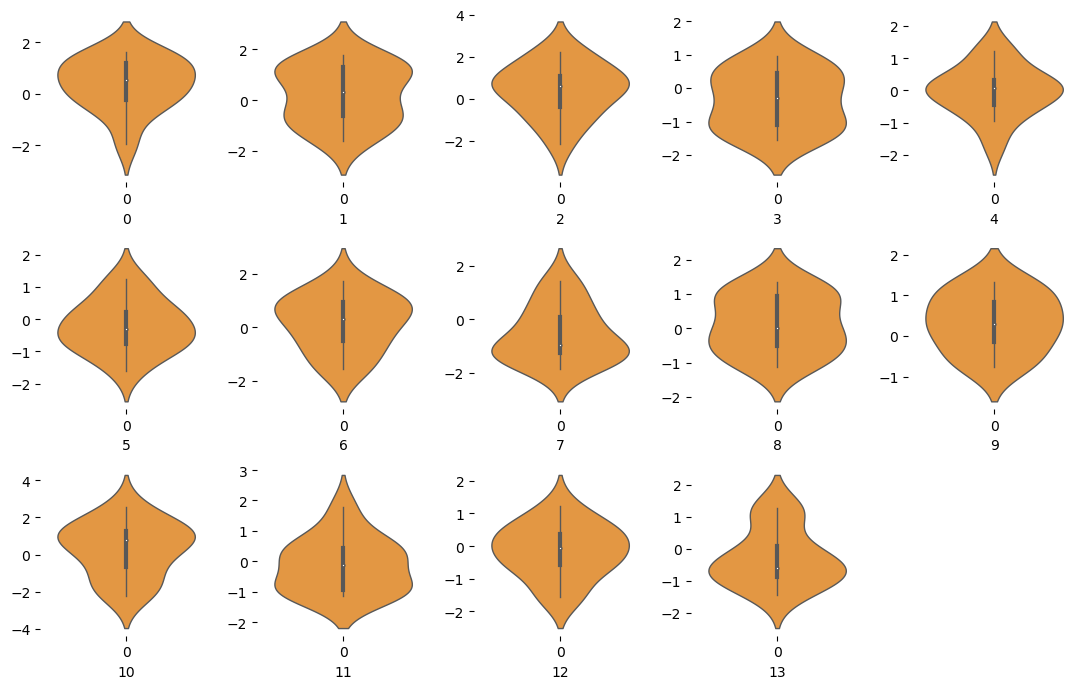

In [6]:
log_trf_df = train_df.copy()

# log-transforming the data
pt = PowerTransformer(method='yeo-johnson')
pt.fit(log_trf_df)
df_log = pt.transform(log_trf_df)

# violinplot of each log-transformed feature 
row_no = 3
col_no = 5
subplot_no = 1

plt.figure(figsize=(11,7))

for col in pd.DataFrame(df_log).columns:
    plt.subplot(row_no, col_no, subplot_no)
    plt.xlabel(col)
    sns.violinplot(data=df_log[col], scale='count', linewidth=1, palette='YlOrBr')
    subplot_no = subplot_no + 1

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

After log-transforming the data, one can clearly notice a big difference in the distributions. Now one can use the Empirical Rule to identify the outliers and remove those who lie 3 standard deviations from the mean. 

In [7]:
# a copy of the datasets
train_copy = pd.DataFrame(train_df.copy())
log_copy = pd.DataFrame(df_log.copy())

# z-score for each column
z_scores = np.abs(zscore(log_copy))

# identifying the outliers above 3 STD
outliers = log_copy[(z_scores > 3).any(axis=1)]

# remove outliers from datasets
df_filt = train_copy.drop(pd.DataFrame(outliers).index)
df_filt_log = log_copy.drop(pd.DataFrame(outliers).index)

### Data exploration after cleaning

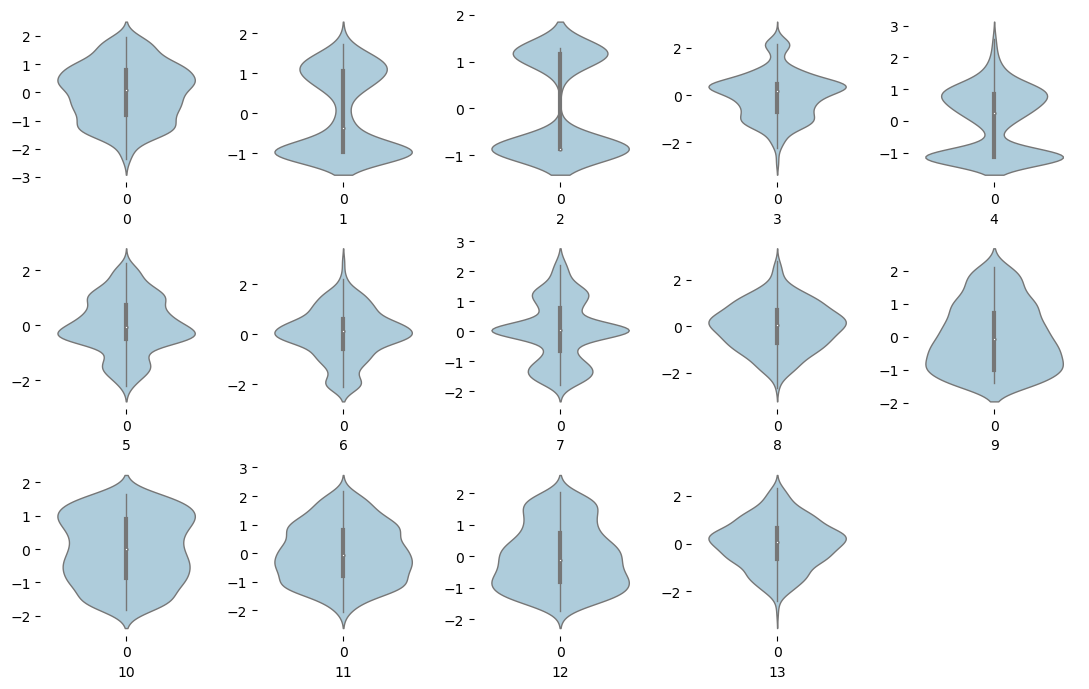

In [8]:
# violinplot of each feature after cleaning
row_no = 3
col_no = 5
subplot_no = 1

plt.figure(figsize=(11,7))

for col in pd.DataFrame(df_filt_log).columns:
    plt.subplot(row_no, col_no, subplot_no)
    plt.xlabel(col)
    sns.violinplot(data=df_filt_log[col], scale='count', linewidth=1, palette='Paired')
    subplot_no = subplot_no + 1

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

After removing the outliers, one can observe that the normal distributions have went a bit off.

*Comment added later on*:
Onwards, I firstly tried to use the cleaned dataset (both the logtransformed and the regular), but found out that the perfomance of the model were poor. Therefore, I ended up using the raw data.

### Data preprocessing

#### Train test split

In [9]:
# splitting features and target in two dataframes
features_train_df = train_df.loc[:, train_df.columns != 'Scoville score']
target_train_df = train_df.loc[:, train_df.columns == 'Scoville score']

# splitting these dataframes in train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    features_train_df, target_train_df,
    test_size=0.3, random_state=1)

### Modelling

#### Data pipeline with regression model

In [10]:
# training a Random Forest Regressor to use the SFS
inpipe_rfr = make_pipeline(StandardScaler(),
                           RandomForestRegressor(random_state=1,
                                                 n_jobs=-1))

# initiating SequentialFeatureSelector to remove non-significant features
pipe_rfr_sfs = SequentialFeatureSelector(estimator=inpipe_rfr,
                                         k_features='best',
                                         forward=True,
                                         floating=False,
                                         scoring='neg_mean_absolute_error',
                                         verbose=0, # hiding warnings/messages about Lokybackend working in background
                                         n_jobs=-1,
                                         cv=5)

# train every function of pipline (includes .fit() and .transform())
pipe_rfr_sfs.fit(X_train, y_train.values.ravel())

# print index of selected features
print("Selected features:", pipe_rfr_sfs.k_feature_idx_)

# remove non-significant features by transforming the dataset
X_selected = pipe_rfr_sfs.transform(X_train)

# initiating a new RFR model to optimize
pipe_rfr = make_pipeline(RandomForestRegressor(random_state=1, n_jobs=-1))

# train every function of pipline (includes .fit() and .transform())
pipe_rfr.fit(X_selected, y_train.values.ravel())

# Optimize parameter values via grid search
# n_estimators range to iterate over
n_estimators_range = [i for i in range(100, 1001, 100)]

# hyperparameters to optimize
param_grid_rfr = {'randomforestregressor__n_estimators': n_estimators_range,
                  'randomforestregressor__max_depth': [1, 5, 10, 15, 25]}

# define the GridSearchCV object with 7-fold cross-validation
gs_rfr = GridSearchCV(estimator=pipe_rfr,
                      param_grid=param_grid_rfr,
                      scoring='neg_mean_absolute_error',
                      cv=7,
                      refit=True,
                      n_jobs=-1,
                      verbose=0) # hiding warnings/messages about Lokybackend working in background);

# fit the grid search object to the training data
gs_rfr.fit(X_selected, y_train.values.ravel())

# print the best hyperparameters and the corresponding score
print('Best parameters RFR:', gs_rfr.best_params_)

y_pred_rfr_mae = gs_rfr.best_estimator_.predict(X_test.iloc[:, list(pipe_rfr_sfs.k_feature_idx_)])

print('Mean absolute error RFR:', mean_absolute_error(y_test, y_pred_rfr_mae))

Selected features: (0, 1, 2, 3, 4, 6, 7)
Best parameters RFR: {'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 800}
Mean absolute error RFR: 271187.60116531


#### Data pipeline with classification model

In [11]:
# Binning train target values
n_bins = 10
y_train_binned, bins = pd.cut(y_train.values.ravel(), n_bins, labels=False, retbins = True)

inpipe_rfc = make_pipeline(StandardScaler(),
                         RandomForestClassifier(random_state=1,
                                               n_jobs=-1))

pipe_sfs = SequentialFeatureSelector(estimator=inpipe_rfc,
                                     k_features='best',
                                     forward=True,
                                     floating=False,
                                     scoring='neg_mean_absolute_error',
                                     verbose=0,
                                     n_jobs=-1,
                                     cv=3)

# train every function of pipline (includes .fit() and .transform())
pipe_sfs.fit(X_train, y_train_binned)

# print selected features and their indices
print("Selected features:", pipe_sfs.k_feature_idx_)

# transform the data to include only the selected features
X_selected = pipe_sfs.transform(X_train)

# use on new model
pipe_rfc_sfs = make_pipeline(RandomForestClassifier(criterion='gini'))

# train every function of pipline (includes .fit() and .transform())
pipe_rfc_sfs.fit(X_selected, y_train_binned)

# Optimize parameter values via grid search
# parameter range to iterate over
n_estimators_range_rfc_sfs = [i for i in range(100, 501, 50)]

param_grid_rfc_sfs = [{'randomforestclassifier__n_estimators': n_estimators_range_rfc_sfs,
                       'randomforestclassifier__max_depth': [1, 5, 10, 15, 25]}]

gs_rfc_sfs = GridSearchCV(estimator=pipe_rfc_sfs,
                       param_grid=param_grid_rfc_sfs,
                       scoring='neg_mean_absolute_error',
                       verbose=0,
                       cv=8,
                       n_jobs=-1)

gs_rfc_sfs = gs_rfc_sfs.fit(X_selected, y_train_binned)

# Print the best hyperparameters and the corresponding score
print('Best parameters:', gs_rfc_sfs.best_params_)

y_pred_rfc_sfs_mae = gs_rfc_sfs.best_estimator_.predict(X_test.iloc[:, list(pipe_sfs.k_feature_idx_)])

print('Mean absolute error RFC:', mean_absolute_error(y_test, y_pred_rfc_sfs_mae))

# predict class labels from test set
y_pred_rfc_sfs = gs_rfc_sfs.best_estimator_.predict(test_df.iloc[:, list(pipe_sfs.k_feature_idx_)])

# converting prediction array to dataframe, and writing to csv-file
final_pred_df_rfc_sfs = pd.DataFrame(y_pred_rfc_sfs, columns=['Scoville score']).astype('int')
final_pred_df_rfc_sfs.to_csv('submission_rfc_sfs.csv', index=True, index_label="Id", sep=',')

Selected features: (0, 1, 2, 4, 6, 7)
Best parameters: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 250}
Mean absolute error RFC: 2176017.134408602


***Comment on how increasing the number of bins affects the performance of the model***

In [12]:
# iterate over increasing no of bins
for bin_no in range(10, 151, 40):    
    y_train_binned, bins = pd.cut(y_train.values.ravel(), bin_no, labels=False, retbins = True)
    gs_rfc_sfs = gs_rfc_sfs.fit(X_selected, y_train_binned)
    y_pred_rfc_sfs_mae = gs_rfc_sfs.best_estimator_.predict(X_test.iloc[:, list(pipe_sfs.k_feature_idx_)])
    
    pred_bins = [bins[int(idx)] for idx in y_pred_rfc_sfs_mae]

    print(f'Number of bins: {bin_no}, Mean absolute error RFC: {mean_absolute_error(y_test, pred_bins)}')

Number of bins: 10, Mean absolute error RFC: 446589.71846774186
Number of bins: 50, Mean absolute error RFC: 406177.9674193548
Number of bins: 90, Mean absolute error RFC: 363213.4163679809
Number of bins: 130, Mean absolute error RFC: 365955.35694789083


For an increasing number of bins, one can observe that the mean absolute error decreases, making the model more accurate.

### Final Evaluation

In [13]:
# predict Random Forest Regressor class labels from test set
y_pred_rfr = gs_rfr.best_estimator_.predict(test_df.iloc[:, list(pipe_rfr_sfs.k_feature_idx_)])

The final evaluation is that the Random Forest Regressor performs the best, with most accurate predictions.

### Kaggle submission

In [14]:
# converting prediction array to dataframe, and writing to csv-file
final_pred_df_rfr = pd.DataFrame(y_pred_rfr, columns=['Scoville score']).astype('int')
final_pred_df_rfr.to_csv('submission_rfr.csv', index=True, index_label="Id", sep=',')